In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount = False)

Mounted at /content/drive


In [ ]:
# extract data from zip file
import zipfile
import os

# Define the path to your zip file and the directory where you want to extract it
zip_file_path = '/content/drive/MyDrive/465 Project/archive.zip'
extract_folder_path = '/content/data'

os.makedirs(extract_folder_path, exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder_path)


In [ ]:
# lib imports
import torch
import os
import numpy as np
import pandas as pd
import random
import cv2

from tqdm import tqdm

from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt

In [ ]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

In [ ]:
import os
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.optim as optim

# Define a custom dataset class
class CustomDataset(Dataset):
    def __init__(self, image_dir, mask_dir, target_size=(128, 128)):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.target_size = target_size
        self.image_files = sorted(os.listdir(image_dir))
        self.mask_files = sorted(os.listdir(mask_dir))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Load and preprocess image
        img = cv2.imread(os.path.join(self.image_dir, self.image_files[idx]))
        img = cv2.resize(img, self.target_size)
        img = np.transpose(img, (2, 0, 1))  # Convert to channels-first format
        img = torch.tensor(img, dtype=torch.float32)

        # Load and preprocess mask
        mask = cv2.imread(os.path.join(self.mask_dir, self.mask_files[idx]))
        mask = cv2.resize(mask, self.target_size)
        mask = np.any(mask > 245, axis=2)  # Convert to boolean mask
        mask = mask.astype(np.float32)
        mask = mask[np.newaxis, :, :]  # Add channel dimension
        mask = torch.tensor(mask, dtype=torch.float32)

        return img, mask


In [ ]:
import torch
import torch.nn as nn

def conv_block_nested(in_channels, mid_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
        nn.ReLU(inplace=True)
    )

class NestedUNet(nn.Module):
    """
    Implementation of Nested UNet model described in https://arxiv.org/pdf/1807.10165.pdf
    """
    def __init__(self, in_ch=3, out_ch=1):
        super(NestedUNet, self).__init__()

        n1 = 64
        filters = [n1, n1 * 2, n1 * 4, n1 * 8, n1 * 16]

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv0_0 = conv_block_nested(in_ch, filters[0], filters[0])
        self.conv1_0 = conv_block_nested(filters[0], filters[1], filters[1])
        self.conv2_0 = conv_block_nested(filters[1], filters[2], filters[2])
        self.conv3_0 = conv_block_nested(filters[2], filters[3], filters[3])
        self.conv4_0 = conv_block_nested(filters[3], filters[4], filters[4])

        self.conv0_1 = conv_block_nested(filters[0] + filters[1], filters[0], filters[0])
        self.conv1_1 = conv_block_nested(filters[1] + filters[2], filters[1], filters[1])
        self.conv2_1 = conv_block_nested(filters[2] + filters[3], filters[2], filters[2])
        self.conv3_1 = conv_block_nested(filters[3] + filters[4], filters[3], filters[3])

        self.conv0_2 = conv_block_nested(filters[0]*2 + filters[1], filters[0], filters[0])
        self.conv1_2 = conv_block_nested(filters[1]*2 + filters[2], filters[1], filters[1])
        self.conv2_2 = conv_block_nested(filters[2]*2 + filters[3], filters[2], filters[2])

        self.conv0_3 = conv_block_nested(filters[0]*3 + filters[1], filters[0], filters[0])
        self.conv1_3 = conv_block_nested(filters[1]*3 + filters[2], filters[1], filters[1])

        self.conv0_4 = conv_block_nested(filters[0]*4 + filters[1], filters[0], filters[0])

        self.final = nn.Sequential(
            nn.Conv2d(filters[0], out_ch, kernel_size=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x0_0 = self.conv0_0(x)
        x1_0 = self.conv1_0(self.pool(x0_0))
        x0_1 = self.conv0_1(torch.cat([x0_0, self.Up(x1_0)], 1))

        x2_0 = self.conv2_0(self.pool(x1_0))
        x1_1 = self.conv1_1(torch.cat([x1_0, self.Up(x2_0)], 1))
        x0_2 = self.conv0_2(torch.cat([x0_0, x0_1, self.Up(x1_1)], 1))

        x3_0 = self.conv3_0(self.pool(x2_0))
        x2_1 = self.conv2_1(torch.cat([x2_0, self.Up(x3_0)], 1))
        x1_2 = self.conv1_2(torch.cat([x1_0, x1_1, self.Up(x2_1)], 1))
        x0_3 = self.conv0_3(torch.cat([x0_0, x0_1, x0_2, self.Up(x1_2)], 1))

        x4_0 = self.conv4_0(self.pool(x3_0))
        x3_1 = self.conv3_1(torch.cat([x3_0, self.Up(x4_0)], 1))
        x2_2 = self.conv2_2(torch.cat([x2_0, x2_1, self.Up(x3_1)], 1))
        x1_3 = self.conv1_3(torch.cat([x1_0, x1_1, x1_2, self.Up(x2_2)], 1))
        x0_4 = self.conv0_4(torch.cat([x0_0, x0_1, x0_2, x0_3, self.Up(x1_3)], 1))

        output = self.final(x0_4)

        return output

# Example usage:
# model = NestedUNet(in_ch=3, out_ch=1)
# print(model)


In [ ]:
# Instantiate the model
device = "cuda" if torch.cuda.is_available() else "cpu"
model = NestedUNet(IMG_CHANNELS, 1).to(device)

In [ ]:
from torchsummary import summary
summary(model, (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           1,792
              ReLU-2         [-1, 64, 128, 128]               0
            Conv2d-3         [-1, 64, 128, 128]          36,928
              ReLU-4         [-1, 64, 128, 128]               0
         MaxPool2d-5           [-1, 64, 64, 64]               0
            Conv2d-6          [-1, 128, 64, 64]          73,856
              ReLU-7          [-1, 128, 64, 64]               0
            Conv2d-8          [-1, 128, 64, 64]         147,584
              ReLU-9          [-1, 128, 64, 64]               0
         Upsample-10        [-1, 128, 128, 128]               0
           Conv2d-11         [-1, 64, 128, 128]         110,656
             ReLU-12         [-1, 64, 128, 128]               0
           Conv2d-13         [-1, 64, 128, 128]          36,928
             ReLU-14         [-1, 64, 1

In [ ]:
import torch

# Assuming model is an instance of NestedUNet or UNet
dummy_input = torch.randn(1, 3, 256, 256).to(device)  # Creating a dummy input tensor

# Pass the dummy input through the model
model.eval()
with torch.no_grad():
    output = model(dummy_input)

# Convert the output probabilities to binary values (0 or 1)
binary_output = torch.round(output)

# Print the binary output
print(output)


tensor([[[[0.5277, 0.5283, 0.5276,  ..., 0.5275, 0.5269, 0.5277],
          [0.5288, 0.5287, 0.5291,  ..., 0.5289, 0.5304, 0.5288],
          [0.5283, 0.5288, 0.5291,  ..., 0.5281, 0.5284, 0.5290],
          ...,
          [0.5291, 0.5288, 0.5297,  ..., 0.5283, 0.5283, 0.5290],
          [0.5282, 0.5292, 0.5295,  ..., 0.5284, 0.5290, 0.5280],
          [0.5284, 0.5283, 0.5290,  ..., 0.5291, 0.5288, 0.5295]]]],
       device='cuda:0')


In [ ]:
################################

# create the checkpoint path

# checkpoint_path = '/content/checkpoint_path/NesU-GrainsTraining.ckpt'
# os.makedirs("/content/checkpoint_path", exist_ok=True)
# checkpoint_dir = os.path.dirname(checkpoint_path)


In [ ]:
from torch.utils.data import random_split

# Define directories for images and masks
image_dir = '/content/data/Grains'
mask_dir = '/content/data/Segmented'

# Create custom dataset
dataset = CustomDataset(image_dir, mask_dir)


train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

# Split the dataset into training and validation sets
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [ ]:
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

# Define optimizer and loss function
# Adjusted hyperparameters
new_learning_rate = 0.0005
new_batch_size = 32

# Define optimizer with new learning rate
optimizer = optim.Adam(model.parameters(), lr=new_learning_rate)

criterion = nn.BCELoss()


# Adjust DataLoader batch size
train_loader = DataLoader(dataset, batch_size=new_batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=new_batch_size, shuffle=False)


# Define callbacks
class ModelCheckpoint:
    def __init__(self, checkpoint_path):
        self.checkpoint_path = checkpoint_path
        self.best_loss = float('inf')

    def __call__(self, model, epoch, train_loss, val_loss):
        if val_loss < self.best_loss:
            torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'train_loss' : train_loss,
            'val_loss': val_loss,
            }, self.checkpoint_path)
            print("Checkpoint saved")
            self.best_loss = val_loss

from datetime import datetime
checkpoint_path = f'/content/drive/MyDrive/465 Project/GrainsTraining{datetime.now().strftime("%d%m%Y %H:%M:%S")}.pt'
# print(checkpoint_path)
# os.makedirs("/content/drive/MyDrive/465 Project", exist_ok=True) # already exists
checkpoint_dir = os.path.dirname(checkpoint_path)
checkpointer = ModelCheckpoint(checkpoint_path)

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
# Use train_loader for training
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item() * inputs.size(0)

    # Average losses
    train_loss /= len(train_loader.dataset)
    val_loss /= len(val_loader.dataset)

    # Print epoch statistics
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    # Call the ModelCheckpoint callback
    checkpointer(model,epoch, train_loss, val_loss)


Epoch [1/20], Train Loss: 0.7612, Val Loss: 0.5767
Checkpoint saved
Epoch [2/20], Train Loss: 0.5704, Val Loss: 0.5020
Checkpoint saved
Epoch [3/20], Train Loss: 0.4628, Val Loss: 0.4376
Checkpoint saved
Epoch [4/20], Train Loss: 0.4324, Val Loss: 0.4541
Epoch [5/20], Train Loss: 0.4231, Val Loss: 0.4191
Checkpoint saved
Epoch [6/20], Train Loss: 0.3996, Val Loss: 0.4029
Checkpoint saved
Epoch [7/20], Train Loss: 0.3948, Val Loss: 0.3864
Checkpoint saved
Epoch [8/20], Train Loss: 0.3801, Val Loss: 0.3746
Checkpoint saved
Epoch [9/20], Train Loss: 0.3693, Val Loss: 0.3568
Checkpoint saved
Epoch [10/20], Train Loss: 0.3646, Val Loss: 0.3634
Epoch [11/20], Train Loss: 0.3607, Val Loss: 0.3510
Checkpoint saved
Epoch [12/20], Train Loss: 0.3481, Val Loss: 0.3459
Checkpoint saved
Epoch [13/20], Train Loss: 0.3401, Val Loss: 0.3329
Checkpoint saved
Epoch [14/20], Train Loss: 0.3286, Val Loss: 0.3647
Epoch [15/20], Train Loss: 0.3388, Val Loss: 0.3507
Epoch [16/20], Train Loss: 0.3287, Val Los

In [ ]:
model.eval()

NestedUNet(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Up): Upsample(scale_factor=2.0, mode='bilinear')
  (conv0_0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (conv1_0): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (conv2_0): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (conv3_0): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): C

In [ ]:
import pandas as pd
import torch

# Load the saved model checkpoint
checkpoint_path = '/content/drive/MyDrive/465 project demo 1/Unet++ ckpts/GrainsTraining30032024 19_56_28.pt'  # Adjust this path accordingly
checkpoint = torch.load(checkpoint_path)
# print(checkpoint.keys())

# Extract specific information from the checkpoint
epoch = checkpoint['epoch']
train_loss = checkpoint['train_loss']
val_loss = checkpoint['val_loss']

# Create a DataFrame for the training and validation loss
loss_data = {'Epoch': [epoch], 'Training Loss': [train_loss], 'Validation Loss': [val_loss]}
loss_df = pd.DataFrame(loss_data)

# Print the DataFrame in Markdown table format
print(loss_df.to_markdown(index=False))


|   Epoch |   Training Loss |   Validation Loss |
|--------:|----------------:|------------------:|
|      17 |        0.275727 |          0.265117 |


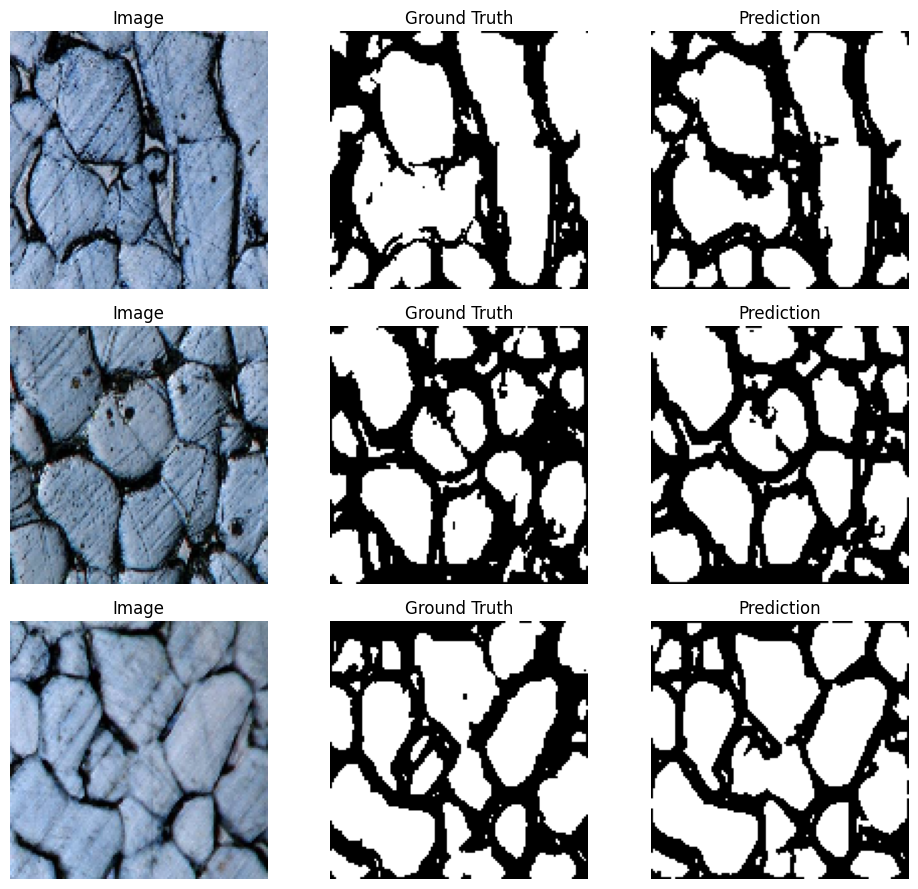

In [ ]:
def plot_example(data_loader, model, device, num_examples=3):
    model.eval()  # Set model to evaluation mode
    images, masks = next(iter(data_loader))  # Get a batch of images and masks from the data loader
    images, masks = images.to(device), masks.to(device)

    with torch.no_grad():  # Disable gradient computation
        outputs = model(images)  # Generate predictions
        outputs = torch.round(outputs)  # Convert probabilities to binary values

    images = images.cpu().numpy()  # Convert tensors to numpy arrays for plotting
    masks = masks.cpu().numpy()
    outputs = outputs.cpu().numpy()

    # Plotting
    fig, axs = plt.subplots(num_examples, 3, figsize=(10, num_examples*3))
    for i in range(num_examples):
        img = np.transpose(images[i], (1, 2, 0))  # Convert from CHW to HWC format for matplotlib
        img = (img - img.min()) / (img.max() - img.min())  # Normalize to [0, 1] for displaying
        mask = masks[i].squeeze()  # Remove channel dimension from mask
        output = outputs[i].squeeze()  # Remove channel dimension from output

        if num_examples == 1:
            axs[0].imshow(img)
            axs[0].set_title("Image")
            axs[0].axis('off')

            axs[1].imshow(mask, cmap='gray')
            axs[1].set_title("Ground Truth")
            axs[1].axis('off')

            axs[2].imshow(output, cmap='gray')
            axs[2].set_title("Prediction")
            axs[2].axis('off')
        else:
            axs[i, 0].imshow(img)
            axs[i, 0].set_title("Image")
            axs[i, 0].axis('off')

            axs[i, 1].imshow(mask, cmap='gray')
            axs[i, 1].set_title("Ground Truth")
            axs[i, 1].axis('off')

            axs[i, 2].imshow(output, cmap='gray')
            axs[i, 2].set_title("Prediction")
            axs[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

# Call the function to plot the examples
plot_example(val_loader, model, device, num_examples=3)


In [ ]:
def calculate_dice_score(true_positive, false_positive, false_negative):
    dice_score = (2 * true_positive) / (2 * true_positive + false_negative + false_positive)
    return dice_score

def calculate_iou_score(intersection, union):
    iou_score = intersection / union
    return iou_score

def dice(probabilistic=False, A=None, B=None, true_positive=None, false_positive=None, false_negative=None):
    if probabilistic:
        return 2 * len(A.intersection(B)) / (len(A) + len(B))
    else:
        return (2 * true_positive) / (2 * true_positive + false_negative + false_positive)

# Example usage:
# For manually segmented images:
dice_score_manual = dice(true_positive_manual, false_positive_manual, false_negative_manual)
iou_score_manual = calculate_iou_score(true_positive_manual, true_positive_manual + false_positive_manual + false_negative_manual)
